# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Axel Gallardo

**Professor**: Pablo Camarillo Ramirez

# Introduction

### 1. Problema a Resolver
Sistema automatizado de perfiles de empleo, evalúa perfiles básicos para orientar a distintas áreas de trabajo en una empresa internacional.
### 2. Desafíos
Volumen de datos
Auditabilidad
detección de sesgos
### 3. Objetivo
Aplicar los principios de big data y las etapas de un data pipeline para diseñar una plataforma escalable y confiable que maneje el consumo y procesamiento de datos básicos de los perfiles de aplicantes a una empresa internacional.
Nótese que al ser información básica habrá sesgos claros no aplicables que no serían recomendables en una implementación real.

# Dataset

### Archivo `profiles.csv` en la carpeta `/opt/spark/work-dir/data/Proyecto/`

### Se guarda como `profiles_t1.csv` en la carpeta `/opt/spark/work-dir/data/Proyecto/exports/`

**Headers:**
- id
- first_name
- last_name
- email
- gender
- age
- education

**Detalles:**
- Creado con Python utilizando la librería **Faker**.
- ~5% de datos faltantes.
- Géneros: "Male", "Female", "Non-binary", "Other", "Prefer not to say".
- Niveles de educación: "No schooling", "Primary", "Middle school", "High school", "University".


In [1]:
%pip install Faker

Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lit, rand, floor, lower, concat, when, array, element_at, size
)
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

from pathlib import Path
import shutil

N = 1000
NULL_RATE = 0.05
SEED = 123

BASE_DIR = "/opt/spark/work-dir/data/Proyecto"
TMP_DIR = f"{BASE_DIR}/profiles_tmp"
FINAL_CSV = f"{BASE_DIR}/profiles.csv"

JDBC_JAR = "/opt/spark/work-dir/jars/postgresql-42.7.8.jar"

spark = (
    SparkSession.builder
    .appName("Profiles generator with Faker")
    .config("spark.jars", JDBC_JAR)
    .getOrCreate()
)

def _first_name_udf(id_value: int) -> str:
    from faker import Faker
    f = Faker("es_MX")
    f.seed_instance(SEED + int(id_value) * 7 + 1)
    return f.first_name()

def _last_name_udf(id_value: int) -> str:
    from faker import Faker
    f = Faker("es_MX")
    f.seed_instance(SEED + int(id_value) * 11 + 2)
    return f.last_name()

def _email_udf(id_value: int, first_name: str, last_name: str) -> str:
    if first_name is None or last_name is None:
        return None
    local = f"{first_name}.{last_name}.{id_value}".lower().replace(" ", "")
    return f"{local}@example.com"

gen_first_name = udf(_first_name_udf, StringType())
gen_last_name  = udf(_last_name_udf,  StringType())
gen_email      = udf(_email_udf,      StringType())

genders = array(*[lit(x) for x in [
    "Male", "Female", "Non-binary", "Other", "Prefer not to say"
]])

educ_levels = array(*[lit(x) for x in [
    "No schooling", "Primary", "Middle school", "High school", "University"
]])

def pick_from(arr, seed_offset: int):
    idx = (floor(rand(SEED + seed_offset) * size(arr)) + lit(1)).cast("int")  # 1-based
    return element_at(arr, idx)

df = spark.range(N).select((col("id") + 1).alias("id"))

df = df.withColumn("first_name", gen_first_name(col("id"))) \
       .withColumn("last_name",  gen_last_name(col("id")))

df = df.withColumn("gender", pick_from(genders, seed_offset=301)) \
       .withColumn("age", (floor(rand(SEED + 302) * (65 - 18 + 1)) + lit(18)).cast("int")) \
       .withColumn("education", pick_from(educ_levels, seed_offset=303))

df = df.withColumn("email", gen_email(col("id"), col("first_name"), col("last_name")))

def with_null(cname: str, seed_offset: int):
    return when(rand(SEED + seed_offset) < lit(NULL_RATE), lit(None)).otherwise(col(cname))

nullable_cols = ["first_name", "last_name", "email", "gender", "age", "education"]
for i, cname in enumerate(nullable_cols):
    df = df.withColumn(cname, with_null(cname, 1000 + i))

df = df.select("id", "first_name", "last_name", "email", "gender", "age", "education")

Path(BASE_DIR).mkdir(parents=True, exist_ok=True)
tmp_path = Path(TMP_DIR)
if tmp_path.exists():
    for p in tmp_path.glob("*"):
        try:
            p.unlink()
        except IsADirectoryError:
            pass
else:
    tmp_path.mkdir(parents=True, exist_ok=True)

(df.coalesce(1)
   .write.mode("overwrite")
   .option("header", "true")
   .csv(TMP_DIR))

part_files = list(tmp_path.glob("part-*.csv"))
if not part_files:
    raise RuntimeError("No se encontró el part-*.csv en la carpeta temporal")

final_path = Path(FINAL_CSV)
if final_path.exists():
    final_path.unlink()

shutil.move(str(part_files[0]), str(final_path))

for p in tmp_path.glob("*"):
    try:
        p.unlink()
    except IsADirectoryError:
        pass
try:
    tmp_path.rmdir()
except OSError:
    pass

25/10/24 23:59:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
from pcamarillor.spark_utils import SparkUtils

profiles_schema_columns = [
    ("id", "int"),
    ("first_name", "string"),
    ("last_name", "string"),
    ("email", "string"),
    ("gender", "string"),
    ("age", "int"),
    ("education", "string"),
]

profiles_schema = SparkUtils.generate_schema(profiles_schema_columns)
profiles_schema

df_profiles = spark.read \
                .option("header", "true") \
                .schema(profiles_schema) \
                .csv("/opt/spark/work-dir/data/Proyecto/")

# Transformations and Actions

In [4]:
from pyspark.sql.functions import trim, lower, col, count, isnull, when

profiles_clean = (
    df_profiles
      .dropDuplicates(["id"])
      .withColumn("first_name",  trim("first_name"))
      .withColumn("last_name",   trim("last_name"))
      .withColumn("email",       lower(trim(col("email"))))
      .withColumn("gender",      trim("gender"))
      .withColumn("education",   trim("education"))
      .filter(col("age").isNotNull())
      .filter((col("age") >= 18) & (col("age") <= 65))
)

profiles_clean_v2 = df_profiles.dropna(
    subset=[c[0] for c in profiles_schema_columns if c[0] != "id"]
)

In [5]:
from pyspark.sql.functions import when, lit, concat_ws, lower, col

profiles_t1 = (
    profiles_clean_v2
      .withColumn("full_name", concat_ws(" ", col("first_name"), col("last_name")))
      .withColumn(
          "education_numeric",
          when(lower(col("education")) == "no schooling", lit(0))
          .when(lower(col("education")) == "primary", lit(1))
          .when(lower(col("education")) == "middle school", lit(2))
          .when(lower(col("education")) == "high school", lit(3))
          .when(lower(col("education")) == "university", lit(4))
          .otherwise(lit(None))
      )
)


# Persistence Data

In [ ]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "public.profiles"
jdbc_props = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver",
}

profiles_out = profiles_t1.select(
    "id", "first_name", "last_name", "email", "gender", "age", "education",
    "full_name", "education_numeric"
)

(profiles_out
    .write
    .mode("overwrite")
    .jdbc(jdbc_url, table_name, properties=jdbc_props))

print(f"DataFrame 'profiles_t1' escrito en PostgreSQL → {table_name}")

df_check = (spark.read
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", table_name)
    .option("user", jdbc_props["user"])
    .option("password", jdbc_props["password"])
    .option("driver", jdbc_props["driver"])
    .load())

print("Filas en Postgres:", df_check.count())
df_check.printSchema()
df_check.show(10, truncate=False)

✅ DataFrame 'profiles_t1' escrito en PostgreSQL → public.profiles
Filas en Postgres: 723
root
 |-- id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- education_numeric: integer (nullable = true)

+---+----------+----------+----------------------------------+-----------------+---+-------------+-------------------+-----------------+
|id |first_name|last_name |email                             |gender           |age|education    |full_name          |education_numeric|
+---+----------+----------+----------------------------------+-----------------+---+-------------+-------------------+-----------------+
|1  |Ignacio   |Velásquez |ignacio.velásquez.1@example.com   |Female           |20 |Primary      |Ignacio Velásquez  |1              

# DAG

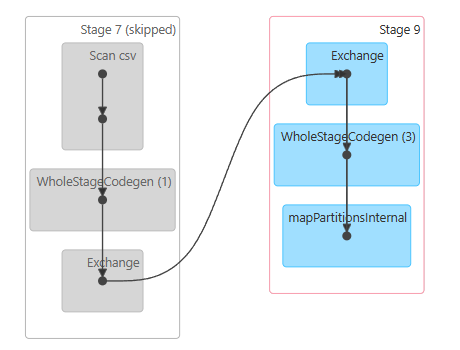